In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import anndata2ri
import gdown
import scipy
import scipy.io
from rpy2.robjects import r

anndata2ri.activate()
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.5 umap==0.5.1 numpy==1.20.1 scipy==1.6.0 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2


In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
    library(SeuratDisk)
})

# Expressions

## Download the data

In [4]:
gdown.download(
    'https://drive.google.com/uc?id=1mXikpKDZ6Nqh42kDHHbwVeMJWc1V9mdB',
    'gayoso2020-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1mXikpKDZ6Nqh42kDHHbwVeMJWc1V9mdB
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/gayoso2020-expressions.h5ad
204MB [00:01, 111MB/s]  


'gayoso2020-expressions.h5ad'

In [5]:
adata = sc.read('gayoso2020-expressions.h5ad')
adata

AnnData object with n_obs × n_vars = 30293 × 4000
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_types_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [6]:
adata_ = ad.AnnData(adata.layers['count'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_types']

In [7]:
%%R -i adata_
rna = as.Seurat(adata_, counts='X', data=NULL)
rna

An object of class Seurat 
4000 features across 30293 samples within 1 assay 
Active assay: RNA (4000 features, 0 variable features)


# Protein

## Download the data

In [8]:
gdown.download(
    'https://drive.google.com/uc?id=1Y4wyzhaXrmW1anoByA5clmzrY6OurL4R',
    'gayoso2020-proteins.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1Y4wyzhaXrmW1anoByA5clmzrY6OurL4R
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/gayoso2020-proteins.h5ad
57.4MB [00:00, 87.6MB/s]


'gayoso2020-proteins.h5ad'

In [9]:
adata = sc.read('gayoso2020-proteins.h5ad')

In [10]:
adata_ = ad.AnnData(adata.layers['count'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_types']

In [11]:
%%R -i adata_
cite = as.Seurat(adata_, counts='X', data=NULL)
cite

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')



An object of class Seurat 
110 features across 30293 samples within 1 assay 
Active assay: RNA (110 features, 0 variable features)


# Run Seurat v4 WNN
Following https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html.

In [12]:
%%R
bm <- rna
bm[["ADT"]] <- CreateAssayObject(counts = cite@assays$RNA@counts)

rm(rna)
rm(cite)

print('Preprocessing RNA...')
DefaultAssay(bm) <- "RNA"
bm <- NormalizeData(bm, verbose=FALSE)
VariableFeatures(bm) <- rownames(bm[["RNA"]])
bm <- ScaleData(bm, verbose=FALSE)

bm <- RunPCA(bm, verbose=FALSE)

print('Preprocessing ADT...')
DefaultAssay(bm) <- "ADT"
VariableFeatures(bm) <- rownames(bm[["ADT"]])
bm <- NormalizeData(bm, normalization.method = 'CLR', margin = 2, verbose=FALSE)
bm <- ScaleData(bm, verbose=FALSE)
bm <- RunPCA(bm, reduction.name = "apca", verbose=FALSE)

bm <- FindMultiModalNeighbors(
       bm, reduction.list = list("pca", "apca"), 
       dims.list = list(1:30, 1:18), modality.weight.name = "RNA.weight"
   )

bm <- RunSPCA(bm, assay = 'RNA', graph = 'wsnn', npcs = 20)

SaveH5Seurat(bm, 'gayoso-seurat.h5seurat', overwrite = TRUE)

[1] "Preprocessing RNA..."
[1] "Preprocessing ADT..."


R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~13s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=27s  


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~43s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 34s
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=06s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Computing sPCA transformation

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: Adding scale.data for RNA

R[write to console]: Adding variable features for RNA

R[write to console]: No feature-level metadata found for RNA

R[write to console]: Adding counts for ADT

R[write to console]: Adding data for ADT

R[write to console]: Adding scale.data for ADT

R[write to console]: Adding variable features for ADT

R[write to console]: No feature-level metadata found for ADT

R[write to console]: Adding cell embeddings for pca

R[write to console]: Adding loadings for pca

R[write to console]: No projected loadings for pca

R[write to console]: Adding standard deviations for pca

R[write to console]: No JackStraw data for pca

R[write to

In [13]:
%%R
Convert("gayoso-seurat.h5seurat", assay="RNA", "gayoso-seurat.h5ad", overwrite=TRUE)

R[write to console]: Validating h5Seurat file

R[write to console]: Adding scale.data from RNA as X

R[write to console]: Adding data from RNA as raw

R[write to console]: Transfering meta.data to obs

R[write to console]: Adding dimensional reduction information for pca

R[write to console]: Adding feature loadings for pca

R[write to console]: Adding dimensional reduction information for spca

R[write to console]: Adding feature loadings for spca

R[write to console]: Adding wsnn as neighbors



In [14]:
integrated = sc.read('gayoso-seurat.h5ad')
integrated

AnnData object with n_obs × n_vars = 30293 × 4000
    obs: 'cell_type', 'nCount_ADT', 'nFeature_ADT', 'RNA.weight', 'ADT.weight'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_spca'
    varm: 'PCs', 'SPCA'
    obsp: 'distances'

In [15]:
latent = sc.AnnData(integrated.obsm['X_spca'])
latent.obs = integrated.obs
latent.obsp['connectivities'] = integrated.uns['neighbors']['distances']

In [16]:
latent.write('../data/integrated/seurat/gayoso-seurat-20.h5ad')

In [17]:
!rm 'gayoso2020-expressions.h5ad'
!rm 'gayoso2020-proteins.h5ad'
!rm 'gayoso-seurat.h5ad'
!rm 'gayoso-seurat.h5seurat'

In [18]:
%%R
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /mnt/home/icb/anastasia.litinetskaya/miniconda3/envs/signac/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Matrix_1.3-2                SeuratDisk_0.0.0.9018      
 [3] SeuratObject_4.0.0          Seurat_4.0.0               
 [5] SingleCellExperiment_1.12.0 SummarizedExperiment_1.20.0
 [7] Biobase_2.50.0              GenomicRanges_1.42.0     

# Visualize results

In [19]:
np.sum(latent.obs_names != adata.obs_names)

0

In [21]:
latent.obs['cell_type'] = adata.obs['cell_types']

In [22]:
sc.pp.neighbors(latent)
sc.tl.umap(latent)

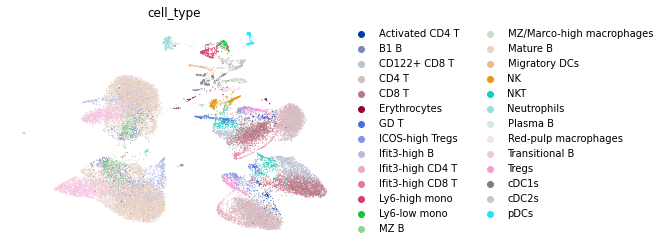

In [23]:
sc.pl.umap(latent, color='cell_type', frameon=False)